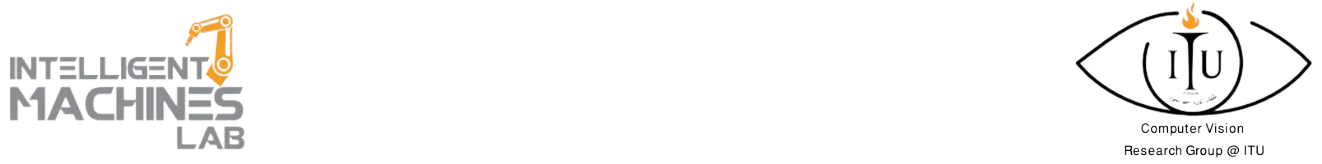

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Sarmad Bin Tahir`

Reg No: `MSCS21020`

Github Link: `your github link here`

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np

# Model Definition

In [79]:

def weights_init(m):
    # TODO: Use He Initialization and use this function to initialize the weights of the model

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='linear')
    if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias, 0)

class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        # TODO: Initialize the encoder Layers
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the encoder will be flattened to a single vector

        # Encoder Layers
        self.encoder_conv1 = nn.Conv2d(input_channels, h_dims[0], kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(h_dims[0], h_dims[1], kernel_size=3, stride=2, padding=1)


        # TODO: Initialize the FC layers to output the mean and log variance

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(h_dims[1] * (INPUT_SIZE // 4) * (INPUT_SIZE // 4), latent_dims)
        self.fc_logvar = nn.Linear(h_dims[1] * (INPUT_SIZE // 4) * (INPUT_SIZE // 4), latent_dims)


        # TODO: Initialize the decoder layers
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the decoder will be a tensor of the same size as the input

        # Decoder Layers
        self.decoder_fc = nn.Linear(latent_dims, h_dims[1] * (INPUT_SIZE // 4) * (INPUT_SIZE // 4))
        self.decoder_conv1 = nn.ConvTranspose2d(h_dims[1], h_dims[0], kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(h_dims[0], input_channels, kernel_size=4, stride=2, padding=1)


        # TODO: Apply weight initialization using the weights_init function
        self.apply(weights_init)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # TODO: Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?

        # Standard deviation
        std = torch.exp(0.5 * logvar)

        # Random noise
        eps = torch.randn_like(std)

        # Sample from the latent distribution
        return mu + eps * std



    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the encoding process

        # Encodes the input data into the latent space representation.
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))


        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Mean
        mu = self.fc_mu(x)

        # Log variance
        logvar = self.fc_logvar(x)

        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        # TODO: Implement the decoding process

        # Decodes the latent representation back to the original data space.

        # Fully connected layer
        z = self.decoder_fc(z)

        # Reshape to conv input
        z = z.view(z.size(0), -1, INPUT_SIZE // 4, INPUT_SIZE // 4)
        z = F.relu(self.decoder_conv1(z))

        # Output should be between 0 and 1
        z = torch.sigmoid(self.decoder_conv2(z))

        return z

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the forward pass

        # Encode
        mu, logvar = self.encode(x)

        # Reparameterization
        z = self.reparametrize(mu, logvar)

        # Decode
        x_reconstructed = self.decode(z)

        # Return reconstructed input, mu, and logvar
        return x_reconstructed, mu, logvar


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

torch.Size([1, 1, 28, 28])


# Dataset Loading

In [80]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 10
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [81]:
# Loading dataset

# TODO: Load the MNIST dataset and prepare the dataloaders.
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set


# Convert images to PyTorch tensors to normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
eval_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [82]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    # Clipping and scaling the image to [0, 1] for display

    # Rescale from [-1, 1] to [0, 1]
    img = (img + 1) / 2

    # Clip values to be in the range [0, 1]
    img = img.clamp(0, 1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

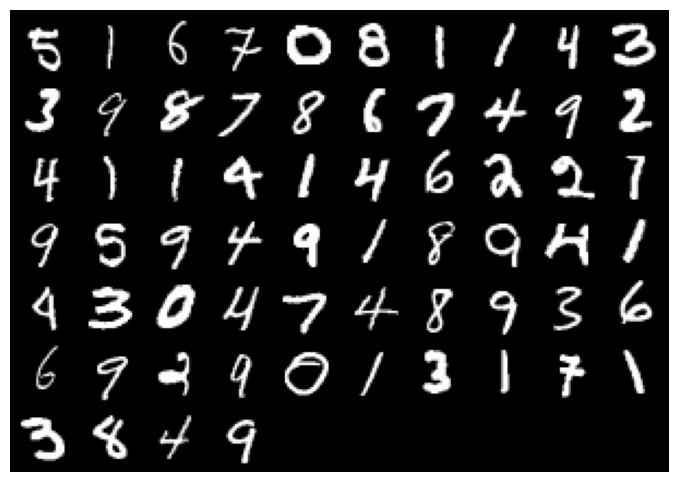

In [83]:
# TODO: Use the plot_image function to plot the images

# Visualize some images from the training set

# Get a batch of images
images, _ = next(iter(train_loader))
plot_image(images)

# Training Loop

In [84]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    # TODO: Implement the VAE loss function

    # VAE loss which is a combination of the reconstruction loss and the KL divergence loss.

    # Reconstruction loss: binary cross-entropy
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE loss
    return BCE + KL

In [74]:
from tqdm import tqdm

# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.


# 1. Initialize the model and the optimizer. You will be using Adam optimizer
model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Initialize lists to store training and evaluation losses
train_losses = []
eval_losses = []

model.train()

# Training Loop
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0

    # TODO: Implement the training loop

    # 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
    # 4. Implement a progress bar to visualize the training progress.
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):

        # Move data to device
        # Normalize to [0, 1] after converting to float
        # Ensure values are in [0, 1]
        data = data.to(DEVICE)
        data = data.float() / 255.0
        data = torch.clamp(data, 0, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        reconstructed_x, mu, logvar = model(data)

        # Calculate the loss
        loss = vae_loss(reconstructed_x, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # 5. Store training and validation losses in train_losses and eval_losses respectively.
        # Store the loss for every VAL_AFTER batches
        if (batch_idx + 1) % VAL_AFTER == 0:
            train_losses.append(running_loss / VAL_AFTER)
            running_loss = 0.0


    # 3. Implement a validation loop that evaluates the model on the validation data.
    # TODO: Implement the evaluation loop


    # Set the model to evaluation mode
    model.eval()
    eval_running_loss = 0.0

    # Disable gradient calculation
    with torch.no_grad():
        for data, _ in eval_loader:

            # Move data to device
            # Normalize to [0, 1] during evaluation
            # Ensure values are in [0, 1]
            data = data.to(DEVICE)
            data = data.float() / 255.0
            data = torch.clamp(data, 0, 1)

            # Forward pass
            reconstructed_x, mu, logvar = model(data)

            # Calculate the loss
            loss = vae_loss(reconstructed_x, data, mu, logvar)
            eval_running_loss += loss.item()

    eval_losses.append(eval_running_loss / len(eval_loader))
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, Eval Loss: {eval_running_loss / len(eval_loader):.4f}')


100%|██████████| 938/938 [00:50<00:00, 18.45it/s]


Epoch [1/10], Train Loss: 77.7438, Eval Loss: 502.9491


100%|██████████| 938/938 [00:51<00:00, 18.10it/s]


Epoch [2/10], Train Loss: 50.7203, Eval Loss: 326.2867


100%|██████████| 938/938 [00:50<00:00, 18.61it/s]


Epoch [3/10], Train Loss: 29.3498, Eval Loss: 193.2340


100%|██████████| 938/938 [00:50<00:00, 18.70it/s]


Epoch [4/10], Train Loss: 24.5319, Eval Loss: 168.1997


100%|██████████| 938/938 [00:49<00:00, 18.97it/s]


Epoch [5/10], Train Loss: 23.9591, Eval Loss: 165.9448


100%|██████████| 938/938 [00:48<00:00, 19.21it/s]


Epoch [6/10], Train Loss: 24.0712, Eval Loss: 165.0136


100%|██████████| 938/938 [00:48<00:00, 19.16it/s]


Epoch [7/10], Train Loss: 23.9435, Eval Loss: 164.5280


100%|██████████| 938/938 [00:50<00:00, 18.42it/s]


Epoch [8/10], Train Loss: 23.8332, Eval Loss: 164.2501


100%|██████████| 938/938 [00:51<00:00, 18.15it/s]


Epoch [9/10], Train Loss: 23.7679, Eval Loss: 164.1115


100%|██████████| 938/938 [00:50<00:00, 18.50it/s]


Epoch [10/10], Train Loss: 23.7627, Eval Loss: 163.9892


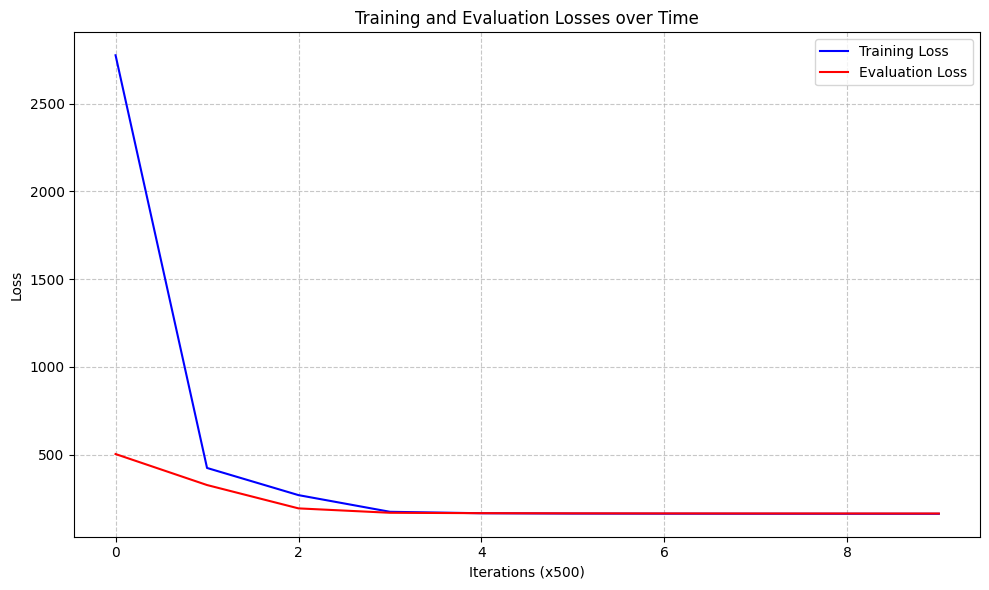

In [75]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

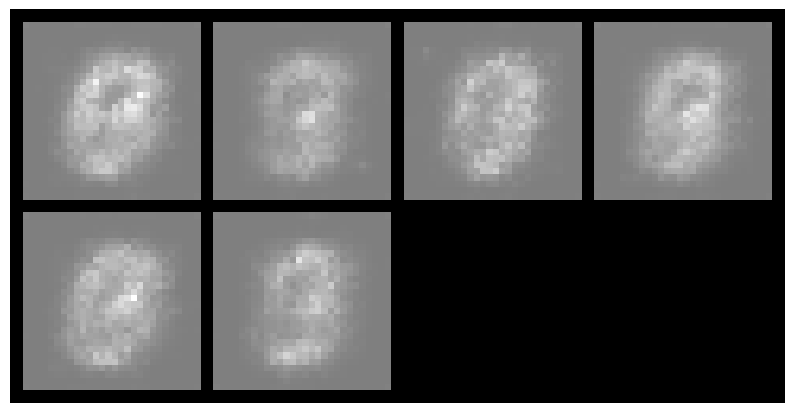

In [76]:
def visualize_generations(model, digit, num_examples):

    # TODO: Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images

    # Set the model to evaluation mode
    model.eval()

    digit_images = []
    for (data, labels) in train_loader:
        digit_images.extend(data[labels == digit].tolist())
        if len(digit_images) >= num_examples:
            break

    digit_images = torch.tensor(digit_images).to(DEVICE)

    # Encode and decode
    with torch.no_grad():
        reconstructed_images, mu, logvar = model(digit_images)

        # Use Min-Max Scaling for visualization (scaling purpose)
        reconstructed_images = (reconstructed_images - reconstructed_images.min()) / (reconstructed_images.max() - reconstructed_images.min())

        # Plot the reconstructed images
        plot_image(reconstructed_images, nrow=num_examples)


digit = 9
num_examples = 4

visualize_generations(model, digit, num_examples)

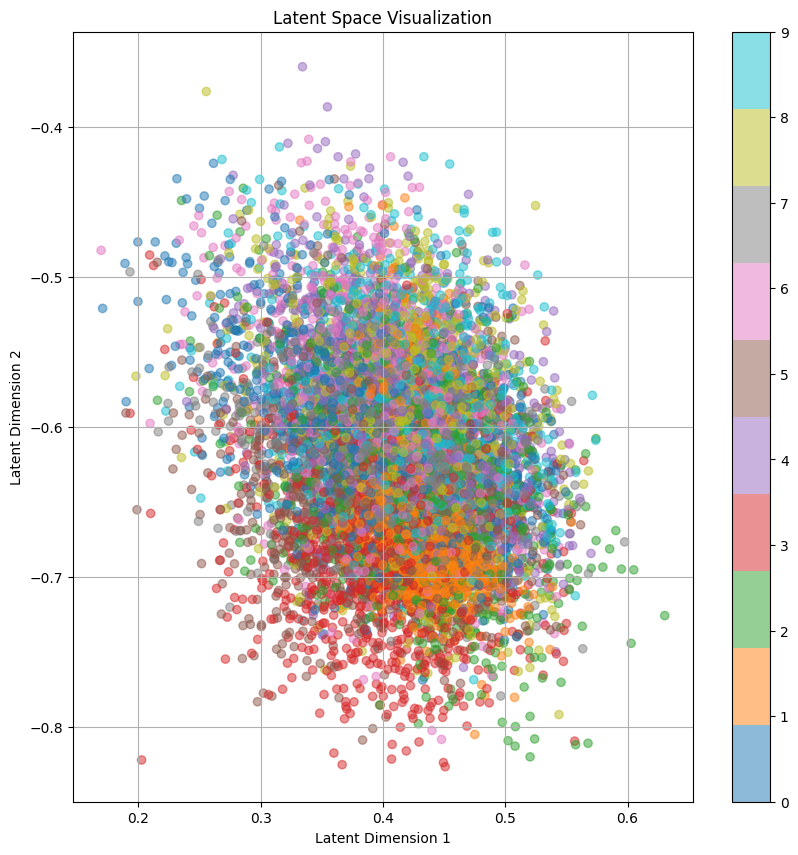

In [77]:
def visualize_latens(dataloader, model):
    # TODO: Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them


    # Set your model's latent space to 2 and train the model
    model.latent_space_dim = 2

    # Set the model to evaluation mode
    model.eval()

    # Encode all samples from MNIST test loader to the latent space
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:

            # Move data to the appropriate device
            data = data.to(DEVICE)

            # Assuming the model has an encode method
            mu, logvar = model.encode(data)

            # Collect the latent representations
            latent_vectors.append(mu.cpu().numpy())

            # Collect labels for coloring
            labels.append(label.cpu().numpy())


    # Concatenate the list of arrays
    latent_vectors = np.concatenate(latent_vectors)

    # Concatenate the list of arrays
    labels = np.concatenate(labels)

    # Plot them using scatter plot to show how model has been able to differentiate between them
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.5)

    # Assuming digits 0-9
    plt.colorbar(scatter, ticks=range(10))
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()


# call visualize function
visualize_latens(test_loader, model)